# Section 1: Planning horizon experiments with 600 cars in Eichstaett

For actual, predicted and errors in utilization, we calculate:
1. mean
2. variance
3. normalized variance: variance/mean

In [16]:
from statistics import mean, median, variance
import numpy as np
import collections

def get_data_from_file(experiment_name, filename):
    with open("results/" + experiment_name + "/" + filename, 'r') as results:
        i =0
        all_data = []
        for line in results:
            i += 1            
            if i % 2 == 0:
                line = line.split(",")
                data_in_invocation = [abs(float(it)) for it in line]
                all_data.append(data_in_invocation)
    return all_data

def prepare_filename(data_kind, step_horizon, planning_steps, planning_period, alpha, beta, tick):
    return str(data_kind) + "_" + \
        str(step_horizon) + "-" + \
        str(planning_steps) + "-" + \
        str(planning_period) + "-" + \
        str(alpha) + "-" + \
        str(beta) + "-" + \
        str(tick) + ".csv"

def get_all_data(experiment_name, data_kind, step_horizons, 
                 planning_steps, planning_period, alpha, beta, tick):
    all_data = []
    for step_horizon in step_horizons:
        filename = prepare_filename(data_kind, step_horizon, 
                                    planning_steps, step_horizon, alpha, beta, step_horizon)
        data = get_data_from_file(experiment_name, filename)    
        flat_list = [item for sublist in data for item in sublist]
        all_data += flat_list
    return all_data  

def calculate_statistics(experiment_name, data_kind, step_horizons, 
                         planning_steps, planning_period, alpha, beta, tick):
    means = dict()
    variances = dict()
    norm_variances = dict(); 
    for step_horizon in step_horizons:
        filename = prepare_filename(data_kind, step_horizon, 
                                    planning_steps, step_horizon, alpha, beta, step_horizon)
        data = get_data_from_file(experiment_name, filename)               
        means[step_horizon] = [mean(d) for d in data]
        variances[step_horizon] = [variance(d) for d in data]
        norm_variances[step_horizon] = [variance(d)/mean(d) for d in data]
    return means, variances, norm_variances    

def calculate_errors(actual_statistics, predicted_statistics, seeds):   
    errors_statistics = dict()
    for step_horizon in step_horizons:
        actual_statistics_for_horizon = actual_statistics[step_horizon]
        predicted_statistics_for_horizon = predicted_statistics[step_horizon]
        errors_statistics_for_horizon = []
        for seed in seeds: 
            errors_statistics_for_seed = actual_statistics_for_horizon[seed] - predicted_statistics_for_horizon[seed]
            errors_statistics_for_horizon.append(errors_statistics_for_seed)
        errors_statistics[step_horizon] = errors_statistics_for_horizon
    return errors_statistics

def validate_data(d, step_horizons, seeds):
    assert(len(d["actual_means"]) == len(step_horizons))
    assert(len(d["actual_variances"]) == len(step_horizons))
    assert(len(d["actual_norm_variances"]) == len(step_horizons))

    assert(len(d["predicted_means"]) == len(step_horizons))
    assert(len(d["predicted_variances"]) == len(step_horizons))
    assert(len(d["predicted_norm_variances"]) == len(step_horizons))

    assert(len(d["error_means"]) == len(step_horizons))
    assert(len(d["error_variances"]) == len(step_horizons))
    assert(len(d["error_norm_variances"]) == len(step_horizons))

    assert(len(d["actual_means"][step_horizons[0]]) == len(seeds))
    assert(len(d["actual_variances"][step_horizons[0]]) == len(seeds))
    assert(len(d["actual_norm_variances"][step_horizons[0]]) == len(seeds))

    assert(len(d["predicted_means"][step_horizons[0]]) == len(seeds))
    assert(len(d["predicted_variances"][step_horizons[0]]) == len(seeds))
    assert(len(d["predicted_norm_variances"][step_horizons[0]]) == len(seeds))

    assert(len(d["error_means"][step_horizons[0]]) == len(seeds))
    assert(len(d["error_variances"][step_horizons[0]]) == len(seeds))
    assert(len(d["error_norm_variances"][step_horizons[0]]) == len(seeds))

print "helper methods loaded!"

helper methods loaded!


In [3]:
experiment_name = "planning-horizon-600cars"
# step_horizons = [50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
step_horizons = [50, 100, 150, 200, 250, 300]
seeds = range(50)

planning_steps = 1 
alpha = 0
beta = 0
# beta = 1

d = dict()
d["actual_means"], d["actual_variances"], d["actual_norm_variances"] = \
    calculate_statistics(experiment_name, "actual", step_horizons, planning_steps, None, alpha, beta, None)
d["predicted_means"], d["predicted_variances"], d["predicted_norm_variances"] = \
    calculate_statistics(experiment_name, "predicted", step_horizons, planning_steps, None, alpha, beta, None)

d["error_means"] = calculate_errors(d["actual_means"], d["predicted_means"], seeds)
d["error_variances"] = calculate_errors(d["actual_variances"], d["predicted_variances"], seeds)
d["error_norm_variances"] = calculate_errors(d["actual_norm_variances"], d["predicted_norm_variances"], seeds)

print "data loaded!"

validate_data(d, step_horizons, seeds) 

print "data validated!"

data loaded!
data validated!


In [4]:
all_data = dict()
all_data["actual"] = get_all_data(experiment_name, "actual", step_horizons, planning_steps, None, alpha, beta, None)
all_data["predicted"] = get_all_data(experiment_name, "predicted", step_horizons, planning_steps, None, alpha, beta, None)

print "flattened data loaded! (to be used in plotting densities)"

flattened data loaded! (to be used in plotting densities)


In [5]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

def prepare_fig_title(experiment_name, seeds, planning_steps, alpha, beta):
    return "Experiment with %s (%s seeds) | planning steps: %s, alpha: %s, beta: %s" % \
        (experiment_name, seeds, planning_steps, alpha, beta)

def box_plot(fig_type, min_plot_value = None, max_plot_value = None):
    fig, ax = plt.subplots()
    od = collections.OrderedDict(sorted(d[fig_type].items()))
    ax.boxplot(od.values(), labels = od.keys())
    ax.set_title(prepare_fig_title(experiment_name, len(seeds), planning_steps, alpha, beta))
    ax.set_ylabel(fig_type.replace("_", " "))
    ax.set_xlabel(experiment_name)
    if min_plot_value is not None and max_plot_value is not None:
        axes = plt.gca()
        axes.set_ylim([min_plot_value,max_plot_value])
    plt.show()
    
def plot_density(data_kind, min_plot_value = None, max_plot_value = None):
    fig, ax = plt.subplots()
    sns.distplot(all_data[data_kind])
    ax.set_title("Distribution of all " + data_kind + " data in the experiment")
    ax.set_ylabel("probability")
    ax.set_xlabel("utilizations")
    if min_plot_value is not None and max_plot_value is not None:
        axes = plt.gca()
        axes.set_ylim([min_plot_value,max_plot_value])    
    plt.show()
    
def find_min_max(data):
    all_values = [item for sublist in data for item in sublist]
    return min(all_values), max(all_values)

print "plotting functions loaded!"

plotting functions loaded!


## Plotting utilization means

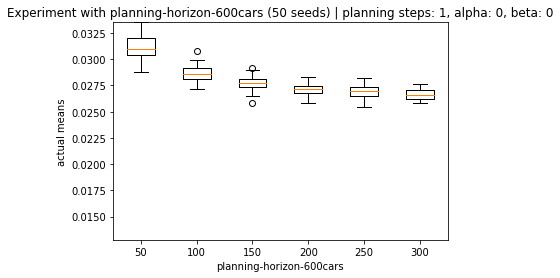

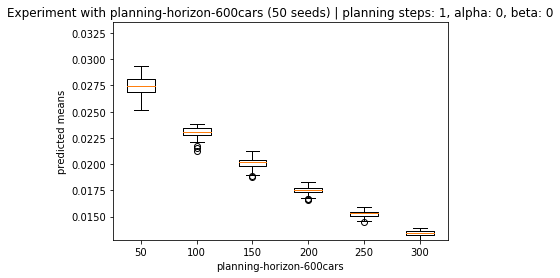

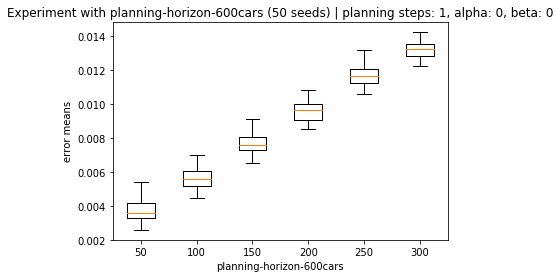

In [6]:
min_plot_value, max_plot_value = find_min_max(d["actual_means"].values() + d["predicted_means"].values())
box_plot("actual_means", min_plot_value, max_plot_value)
box_plot("predicted_means", min_plot_value, max_plot_value)
box_plot("error_means")

## Plotting utilization variances

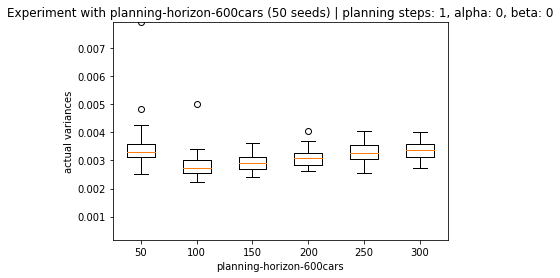

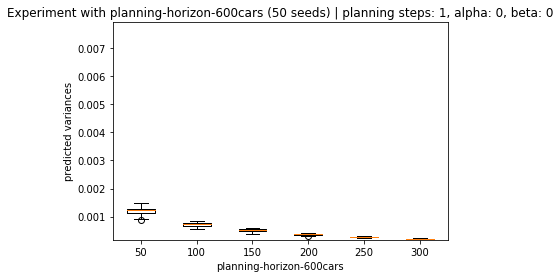

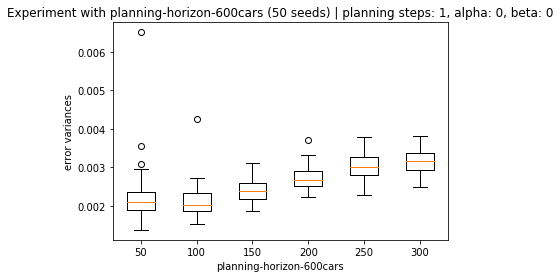

In [7]:
min_plot_value, max_plot_value = find_min_max(d["actual_variances"].values() + d["predicted_variances"].values())
box_plot("actual_variances", min_plot_value, max_plot_value)
box_plot("predicted_variances", min_plot_value, max_plot_value)
box_plot("error_variances")

## Plotting normalized variances in utilization

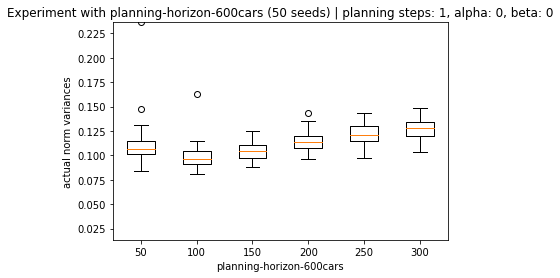

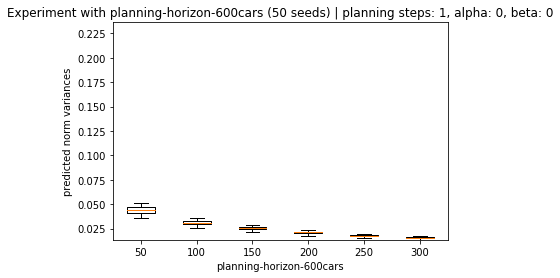

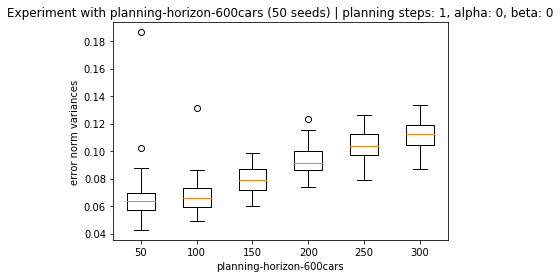

In [8]:
min_plot_value, max_plot_value = find_min_max(d["actual_norm_variances"].values() + d["predicted_norm_variances"].values())
box_plot("actual_norm_variances", min_plot_value, max_plot_value)
box_plot("predicted_norm_variances", min_plot_value, max_plot_value)
box_plot("error_norm_variances")

## Probability densities over all data (all horizons)

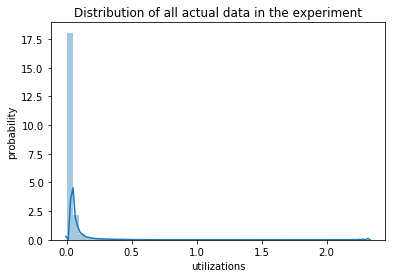

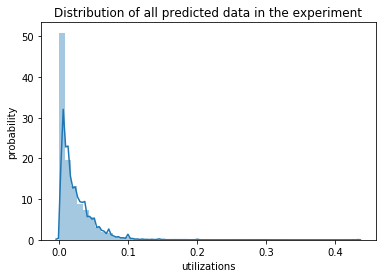

In [9]:
plot_density("actual")
plot_density("predicted")

# Section 2: Sensitivity analysis with different number of cars

In [17]:
experiment_name_prefix = "planning-horizon-"
step_horizons = [50, 100, 150, 200, 250, 300]
seeds = range(50)

planning_steps = 1 
alpha = 0
beta = 0

d = dict()
for cars_no in [200, 400, 500, 600]:
    print "getting data for " + str(cars_no)
    experiment_name = experiment_name_prefix + str(cars_no) + "cars"
    d[cars_no] = dict()
    d[cars_no]["actual_means"], d[cars_no]["actual_variances"], d[cars_no]["actual_norm_variances"] = \
        calculate_statistics(experiment_name, "actual", step_horizons, planning_steps, None, alpha, beta, None)
    d[cars_no]["predicted_means"], d[cars_no]["predicted_variances"], d[cars_no]["predicted_norm_variances"] = \
        calculate_statistics(experiment_name, "predicted", step_horizons, planning_steps, None, alpha, beta, None)

    d[cars_no]["error_means"] = \
        calculate_errors(d[cars_no]["actual_means"], d[cars_no]["predicted_means"], seeds)
    d[cars_no]["error_variances"] = \
        calculate_errors(d[cars_no]["actual_variances"], d[cars_no]["predicted_variances"], seeds)
    d[cars_no]["error_norm_variances"] = \
        calculate_errors(d[cars_no]["actual_norm_variances"], d[cars_no]["predicted_norm_variances"], seeds)

    print "data for " + str(cars_no) +" loaded!"

    validate_data(d[cars_no], step_horizons, seeds) 
    print "data validated!"

getting data for 200
data for 200 loaded!
data validated!
getting data for 400
data for 400 loaded!
data validated!
getting data for 500
data for 500 loaded!
data validated!
getting data for 600
data for 600 loaded!
data validated!


In [18]:
import pandas as pd 
import seaborn as sns
import matplotlib.pylab as plt

def plot_sensitivity_analysis(fig_type):
    averages = dict()
    for cars_no in d.keys(): 
        od = collections.OrderedDict(sorted(d[cars_no][fig_type].items()))
        values = [mean(l) for l in od.values()]
        keys = [str(k) for k in od.keys()]
        averages[str(cars_no)] = pd.Series(values, index = keys)    
    df = pd.DataFrame(averages) 
    print "===================="
    show_heatmap(df, fig_type)
    print df
    print "===================="
    return df

def show_heatmap(df, fig_type):
    ax = sns.heatmap(df, linewidth=0.5)
    ax.set_title(fig_type.replace("_", " "))
    ax.set_ylabel("step horizons")
    ax.set_xlabel("number of cars")
    plt.show()
    
print "heatmap functions loaded!"

heatmap functions loaded!


## Plotting averages of utilization means in different horizons and number of cars

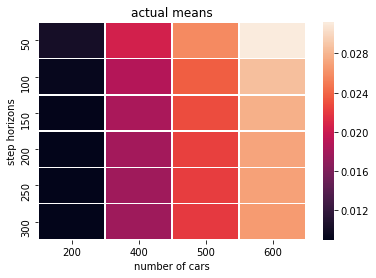

          200       400       500       600
50   0.010285  0.020570  0.025747  0.031173
100  0.009377  0.018850  0.023649  0.028639
150  0.009116  0.018281  0.022888  0.027742
200  0.009005  0.017920  0.022409  0.027112
250  0.009001  0.017819  0.022231  0.026952
300  0.008992  0.017673  0.022041  0.026656


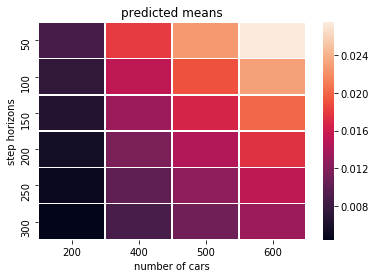

          200       400       500       600
50   0.008841  0.018018  0.022661  0.027433
100  0.007479  0.015300  0.019145  0.023010
150  0.006600  0.013407  0.016738  0.020097
200  0.005771  0.011671  0.014571  0.017510
250  0.005050  0.010173  0.012684  0.015238
300  0.004467  0.008945  0.011163  0.013423


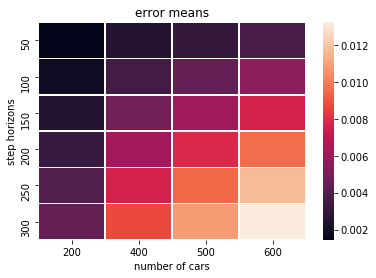

          200       400       500       600
50   0.001444  0.002552  0.003086  0.003740
100  0.001898  0.003550  0.004504  0.005629
150  0.002516  0.004874  0.006151  0.007645
200  0.003234  0.006249  0.007837  0.009602
250  0.003951  0.007646  0.009547  0.011714
300  0.004525  0.008727  0.010878  0.013233


In [19]:
for fig_type in ['actual_means', 'predicted_means', 'error_means']:
    plot_sensitivity_analysis(fig_type)

## Plotting averages of utilization variances in different horizons and number of cars

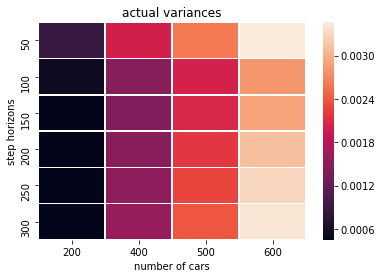

          200       400       500       600
50   0.000899  0.002004  0.002614  0.003461
100  0.000566  0.001461  0.002027  0.002823
150  0.000470  0.001416  0.002074  0.002899
200  0.000465  0.001483  0.002193  0.003108
250  0.000451  0.001542  0.002286  0.003285
300  0.000449  0.001587  0.002395  0.003403


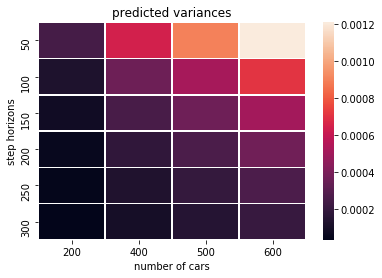

          200       400       500       600
50   0.000247  0.000647  0.000902  0.001210
100  0.000126  0.000363  0.000519  0.000713
150  0.000084  0.000254  0.000366  0.000509
200  0.000059  0.000182  0.000265  0.000370
250  0.000043  0.000132  0.000194  0.000270
300  0.000033  0.000101  0.000148  0.000207


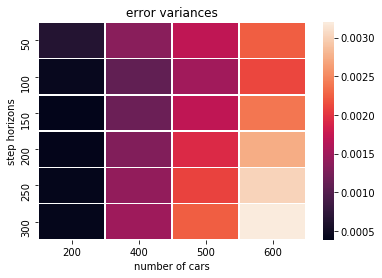

          200       400       500       600
50   0.000653  0.001357  0.001711  0.002250
100  0.000440  0.001098  0.001508  0.002111
150  0.000385  0.001161  0.001707  0.002390
200  0.000405  0.001301  0.001928  0.002739
250  0.000408  0.001409  0.002092  0.003015
300  0.000416  0.001486  0.002247  0.003196


In [20]:
for fig_type in ['actual_variances', 'predicted_variances', 'error_variances']:
    plot_sensitivity_analysis(fig_type)

## Plotting averages of normalized variances in different horizons and number of cars

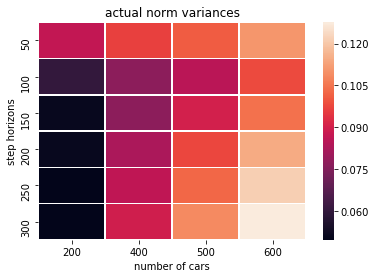

          200       400       500       600
50   0.086976  0.096732  0.101074  0.110595
100  0.060173  0.077386  0.085601  0.098383
150  0.051380  0.077341  0.090468  0.104391
200  0.051479  0.082634  0.097762  0.114519
250  0.049990  0.086460  0.102738  0.121739
300  0.049840  0.089755  0.108574  0.127569


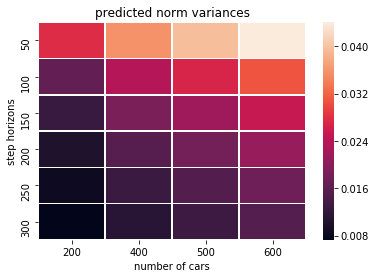

          200       400       500       600
50   0.027789  0.035795  0.039720  0.044048
100  0.016744  0.023635  0.027031  0.030928
150  0.012754  0.018912  0.021846  0.025295
200  0.010271  0.015543  0.018146  0.021089
250  0.008462  0.012977  0.015282  0.017709
300  0.007289  0.011257  0.013247  0.015384


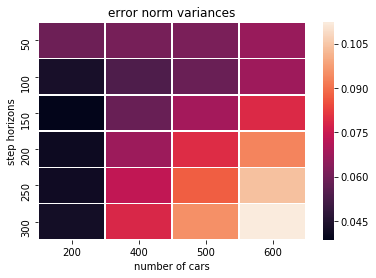

          200       400       500       600
50   0.059187  0.060937  0.061354  0.066547
100  0.043429  0.053751  0.058569  0.067455
150  0.038626  0.058429  0.068622  0.079096
200  0.041208  0.067091  0.079616  0.093431
250  0.041527  0.073483  0.087455  0.104030
300  0.042551  0.078498  0.095327  0.112186


In [21]:
for fig_type in ['actual_norm_variances', 'predicted_norm_variances', 'error_norm_variances']:
    plot_sensitivity_analysis(fig_type)

# Something here